In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [2]:
from super_gradients.training import models

The console stream is logged into /root/sg_logs/console.log


[2023-05-23 05:01:28] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-23 05:01:38] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-23 05:01:38] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-23 05:01:38] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-23 05:01:38] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/content/checkpoints'
trainer = Trainer(experiment_name='/content/nas_l_run', ckpt_root_dir=CHECKPOINT_DIR)

In [4]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [5]:
dataset_params = {
    'data_dir':'/content/drive/MyDrive/TATA_splitted',
    'train_images_dir':'/content/drive/MyDrive/TATA_splitted/train/Images',
    'train_labels_dir':'/content/drive/MyDrive/TATA_splitted/train/Labels',
    'val_images_dir':'/content/drive/MyDrive/TATA_splitted/val/Images',
    'val_labels_dir':'/content/drive/MyDrive/TATA_splitted/val/Labels',
    'classes': ['tata_logo']
}

In [6]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from IPython.display import clear_output
from PIL import Image

def is_valid_jpeg(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception:
        return False

In [7]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

In [8]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/drive/MyDrive/NAS MOdels/ckpt_best.pth")

[2023-05-23 05:07:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/NAS MOdels/ckpt_best.pth EMA checkpoint.


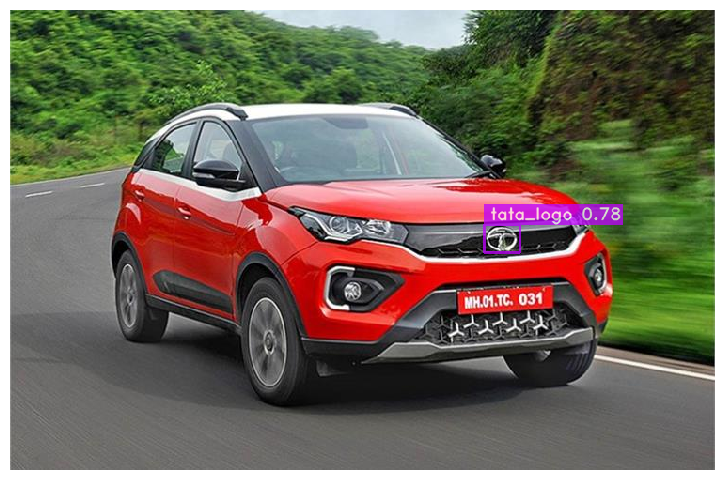

In [9]:
# predicting an image
img_url = '/content/drive/MyDrive/TATA_splitted/train/Images/02845cef-0d05-47b8-bbf7-0611eefac362.jpeg'
best_model.predict(img_url, conf=0.39).show()

In [10]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"
input_video_path = "/NRrP1S7LxQE.mp4" 
output_video_path = "tata_yolonas_l_detections.mp4"
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 1481/1481 [1:45:30<00:00,  4.27s/it]
